## Cats vs Dogs Classification with PyTorch

This notebook demonstrates:
- Loading a custom dataset of cats and dogs images
- Creating DataLoaders
- Defining a convolutional neural network
- Training the model
- Saving and loading the trained model
- Running inference on new images

This exercise is a way to **combine all concepts from the three previous notebooks**:
1. Dataset and DataLoader
2. Model creation and training
3. Model loading and inference


In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Loading the Dataset

We use `ImageFolder` to load images organized in folders `data/cats` and `data/dogs`.  
Images are resized to 64x64 and converted to tensors.

In [2]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root="data", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

images, labels = next(iter(dataloader))
print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)

Image batch shape: torch.Size([32, 3, 64, 64])
Label batch shape: torch.Size([32])


## Defining the Neural Network

- Three convolutional layers with ReLU and MaxPooling  
- Flatten layer  
- Two fully connected layers  
- Output layer with 2 classes (`cat` and `dog`)


In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 64, 3)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64*6*6, 128)
        self.relu = nn.ReLU()

        self.fc2 = nn.Linear(128, 2)
    
    def forward(self, x):
        x = self.relu(self.pool1(self.conv1(x)))
        x = self.relu(self.pool2(self.conv2(x)))
        x = self.relu(self.pool3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2304, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


## Loss Function and Optimizer

- CrossEntropyLoss for 2-class classification  
- Adam optimizer with learning rate 0.001

In [4]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Training Function

For each batch:
1. Move inputs and labels to device
2. Forward pass
3. Compute loss
4. Backward pass
5. Update weights

In [5]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss_val, current = loss.item(), (batch+1)*len(X)
            print(f"loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]")

## Training the Model

We train for 10 epochs.  
Since we currently do not have a separate test set, training is performed on all data.

In [10]:
os.makedirs("model", exist_ok=True)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(dataloader, model, loss_fn, optimizer)
print("Training completed!")

Epoch 1
-------------------------------
loss: 0.693106  [   32/24998]


c:\Users\luigi\anaconda3\envs\pytorch\lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


loss: 0.703886  [ 3232/24998]
loss: 0.688139  [ 6432/24998]
loss: 0.684617  [ 9632/24998]
loss: 0.570531  [12832/24998]
loss: 0.667295  [16032/24998]
loss: 0.663636  [19232/24998]
loss: 0.599698  [22432/24998]
Epoch 2
-------------------------------
loss: 0.488941  [   32/24998]
loss: 0.528082  [ 3232/24998]
loss: 0.465668  [ 6432/24998]
loss: 0.437013  [ 9632/24998]
loss: 0.654666  [12832/24998]
loss: 0.470070  [16032/24998]
loss: 0.511072  [19232/24998]
loss: 0.720545  [22432/24998]
Epoch 3
-------------------------------
loss: 0.379441  [   32/24998]
loss: 0.537733  [ 3232/24998]
loss: 0.504863  [ 6432/24998]
loss: 0.623161  [ 9632/24998]
loss: 0.366699  [12832/24998]
loss: 0.441945  [16032/24998]
loss: 0.346760  [19232/24998]
loss: 0.337732  [22432/24998]
Epoch 4
-------------------------------
loss: 0.469308  [   32/24998]
loss: 0.313480  [ 3232/24998]
loss: 0.465097  [ 6432/24998]
loss: 0.319734  [ 9632/24998]
loss: 0.493285  [12832/24998]
loss: 0.546158  [16032/24998]
loss: 0.56

## Saving the Trained Model

Save the model state for later use.

In [11]:
torch.save(model.state_dict(), "model/model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Inference on New Images

We can now use the trained model to predict new images stored in the folder `test_img`.

In [14]:
model.eval()
TEST_PATH = "test_img"
class_names = ['cat', 'dog']

for img_name in os.listdir(TEST_PATH):
    img_path = os.path.join(TEST_PATH, img_name)
    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image)
        pred = output.argmax(dim=1).item()
        print(f"{img_name}: {class_names[pred]}")

cat1.jpg: cat
cat2.jpg: cat
cat3.jpg: cat
cat4.jpg: cat
cat5.jpg: cat
dog1.jpg: dog
dog2.jpg: dog
dog3.jpg: dog
dog4.jpg: dog
dog5.jpg: dog


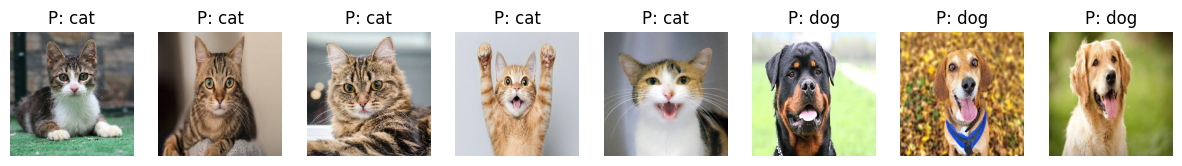

In [ ]:
n_images = max(8, len(os.listdir(TEST_PATH)))

plt.figure(figsize=(15, 5))
for i, img_name in enumerate(os.listdir(TEST_PATH)[:n_images]):
    img_path = os.path.join(TEST_PATH, img_name)
    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)
    image = image.resize((256,256), Image.Resampling.NEAREST)
    
    with torch.no_grad():
        output = model(input_tensor)
        pred = output.argmax(dim=1).item()
    
    plt.subplot(1, n_images, i+1)
    plt.imshow(image)
    plt.title(f"P: {class_names[pred]}")
    plt.axis('off')
plt.show()